

For this analysis, we're modeling a **4:1 split-rate tax** where land is taxed at four times the rate of buildings.

## Policy Definition for Spokane


For this analysis, we're modeling:
- **Revenue-neutral** property tax split for the South Bend School Corporation
- **4:1 land-to-building tax ratio** (partial LVT shift)
- **Existing exemptions and abatements** continue to apply
- **Focus on school corporation taxes** (which bypass Indiana's property tax caps)

Let's begin by importing the necessary libraries and utility functions.


In [1]:
# Utility function to ensure DataFrames with geometry are converted to GeoDataFrames
import geopandas as gpd
import pandas as pd
from shapely import wkt

def ensure_geodataframe(df, geometry_col='geometry'):
    """
    Ensures that a DataFrame with geometry column is converted to a GeoDataFrame.
    If conversion fails, tries to robustly decode geometry values before failing.
    
    Args:
        df: DataFrame or GeoDataFrame
        geometry_col: Name of the geometry column
    
    Returns:
        GeoDataFrame with proper CRS set
    """
    import shapely
    import binascii

    def try_decode_geometry(val):
        """
        Try to decode a geometry value that may be:
        - Already a shapely geometry
        - A WKT string
        - A WKB hex string (bytes or str)
        - A WKB bytes object
        If it cannot be decoded, returns None.
        """
        if isinstance(val, shapely.geometry.base.BaseGeometry):
            return val
        if val is None or (isinstance(val, float) and pd.isna(val)):
            return None
        # Try WKT
        if isinstance(val, str):
            try:
                # Try WKT first
                return shapely.wkt.loads(val)
            except Exception:
                pass
            try:
                # Try WKB hex string
                return shapely.wkb.loads(binascii.unhexlify(val))
            except Exception:
                pass
        # Try WKB bytes
        if isinstance(val, (bytes, bytearray)):
            try:
                return shapely.wkb.loads(val)
            except Exception:
                pass
        return None

    # If already a GeoDataFrame, ensure CRS is set
    if isinstance(df, gpd.GeoDataFrame):
        if df.crs is None:
            df = df.set_crs(epsg=4326)  # WGS84
        return df

    # If regular DataFrame with geometry column, convert to GeoDataFrame
    if geometry_col in df.columns:
        # Convert geometry column from WKT strings to geometry objects if needed
        if df[geometry_col].dtype == 'object':
            try:
                df[geometry_col] = df[geometry_col].apply(wkt.loads)
            except Exception:
                # If wkt.loads fails, try to robustly decode geometry values
                try:
                    df[geometry_col] = df[geometry_col].apply(try_decode_geometry)
                    # Remove rows where geometry could not be decoded
                    n_invalid = df[geometry_col].isna().sum()
                    if n_invalid > 0:
                        print(f"⚠️ {n_invalid} rows had invalid geometry and will be dropped.")
                        df = df[df[geometry_col].notna()]
                except Exception as e:
                    print(f"❌ Could not decode geometry: {e}")
                    raise

        # Convert to GeoDataFrame
        try:
            df = gpd.GeoDataFrame(df, geometry=geometry_col)
        except Exception as e:
            # Try to robustly decode geometry and try again
            try:
                df[geometry_col] = df[geometry_col].apply(try_decode_geometry)
                n_invalid = df[geometry_col].isna().sum()
                if n_invalid > 0:
                    print(f"⚠️ {n_invalid} rows had invalid geometry and will be dropped.")
                    df = df[df[geometry_col].notna()]
                df = gpd.GeoDataFrame(df, geometry=geometry_col)
            except Exception as e2:
                print(f"❌ Could not convert to GeoDataFrame after robust decode: {e2}")
                raise

        # Set CRS if not already set
        if df.crs is None:
            df = df.set_crs(epsg=4326)  # WGS84

        return df

    # Return as-is if no geometry column found
    return df

print("✅ Utility function loaded: ensure_geodataframe()")


✅ Utility function loaded: ensure_geodataframe()


In [2]:
import sys
import pandas as pd
sys.path.append('..')  # Add parent directory to path
from cloud_utils import get_feature_data, get_feature_data_with_geometry
from lvt_utils import model_split_rate_tax, calculate_current_tax, model_full_building_abatement, model_stacking_improvement_exemption
from census_utils import get_census_data, get_census_blockgroups_shapefile, get_census_data_with_boundaries, match_to_census_blockgroups

scrape_data = 0

## Step 1: Getting the Data

The first step in modeling an LVT shift is obtaining property tax data. Most counties make this information publicly accessible through open data portals or GIS systems.

For St. Joseph County (which includes South Bend), we can access parcel data through their ArcGIS services. The base URL below provides access to various property datasets including:

- **Parcel_Civic**: Main parcel dataset with tax information, property types, and assessed values
- **parcel_boundaries**: Geographic boundaries for spatial analysis

### Key Data Elements We Need:
- **Full Market Value (FMV)**: Total assessed property value
- **Land Value**: Assessed value of land only  
- **Improvement Value**: Assessed value of buildings/structures
- **Exemption amounts**: Various tax exemptions applied
- **Property characteristics**: Type, location, tax district

Let's fetch the main parcel dataset:


In [3]:

import os
from datetime import datetime
import glob

# Directory to save/load data
data_dir = "data/spokane"
os.makedirs(data_dir, exist_ok=True)

if scrape_data == 1:
    # Base URL for the ArcGIS services
    base_url = "https://services1.arcgis.com/ozNll27nt9ZtPWOn/ArcGIS/rest/services/"
    # Fetch the main parcel dataset with tax info
    parcel_civic_df = get_feature_data_with_geometry('Parcels', base_url)
    # Save with geometry to parquet, with current date
    today_str = datetime.now().strftime("%Y_%m_%d")
    out_path = os.path.join(data_dir, f"spokane_parcels_{today_str}.parquet")
    parcel_civic_df.to_parquet(out_path, index=False)
    print(f"Saved new scrape to {out_path}")
else:
    # Find the most recent parquet file in the data_dir
    files = glob.glob(os.path.join(data_dir, "spokane_parcels_*.parquet"))
    if not files:
        raise FileNotFoundError("No previously scraped parcel files found in data/spokane/")
    # Sort files by date in filename
    files_sorted = sorted(files, key=lambda x: datetime.strptime(os.path.basename(x).replace("spokane_parcels_", "").replace(".parquet", ""), "%Y_%m_%d"), reverse=True)
    latest_file = files_sorted[0]
    print(f"Loading most recent scrape: {latest_file}")
    parcel_civic_df = pd.read_parquet(latest_file)

# Ensure parcel_civic_df is a proper GeoDataFrame
parcel_civic_df = ensure_geodataframe(parcel_civic_df)
print(f"✅ Parcel data loaded as {type(parcel_civic_df).__name__} with CRS: {parcel_civic_df.crs}")


Loading most recent scrape: data/spokane/spokane_parcels_2025_07_09.parquet
✅ Parcel data loaded as GeoDataFrame with CRS: EPSG:4326


Charge data comes from:  https://gisdatacatalog-spokanecounty.opendata.arcgis.com/pages/parcel-data-file-downloads


In [4]:
# Load charge_info_1 and charge_info_2 from Excel files in data/spokane/
charge_info_1 = pd.read_excel(os.path.join(data_dir, "charge_info_1.xlsx"))
charge_info_2 = pd.read_excel(os.path.join(data_dir, "charge_info_2.xlsx"))

# Check if charge_info_1 and charge_info_2 have the same columns
if list(charge_info_1.columns) == list(charge_info_2.columns):
    millage_df = pd.concat([charge_info_1, charge_info_2], ignore_index=True)
else:
    print("❌ charge_info_1 and charge_info_2 do not have the same column names.")
    millage_df = None

# Display the dataframe if it was created
if millage_df is not None:
    pd.set_option('display.max_columns', None)
    display(millage_df.head(5))


print("Counts of charge_type in millage_df:")
if millage_df is not None:
    print(millage_df['charge_type'].value_counts(dropna=False).to_string())
else:
    print("millage_df is None, cannot print charge_type counts.")


,parcel,tax_year,charge_type,charge_amt,charge_due
0,0.00004,2025,A/V Principal-Excess,100.09,0.00
1,0.00004,2025,A/V Principal-Regular,125.43,0.00
2,0.000041,2025,A/V Principal-Regular,62.24,31.12
3,0.000041,2025,A/V Principal-Excess,65.68,32.84
4,0.000057,2025,A/V Principal-Regular,36.80,0.00


Counts of charge_type in millage_df:
charge_type
A/V Principal-Regular                                236251
A/V Principal-Excess                                 227487
Weed Control Principal  WCWEED1                      212216
Soil Conservation Principal  CNSV1                   209633
Aquifer Principal  HOUSE                              61417
State Forest Patrol Principal  SFFIRE1                46627
State Forest Patrol Principal  SFFIRE3                46625
State Forest Patrol Principal  SFFIRE2                46597
Stormwater Principal Spokane Valley RES1              29924
Stormwater Principal  RES1                            27868
Irrigation District Principal                         21377
Stormwater Principal Liberty Lake RES1                 4090
Stormwater Principal North Spokane RES1                4034
Stormwater Principal Spokane Valley COM1               3608
Personal Property Late Filing Penalty - Excess         3096
Personal Property Late Filing Penalty - Regular    

In [5]:
print("Column names in parcel_civic_df:")
print(parcel_civic_df.columns.tolist())
pd.set_option('display.max_columns', None)
display(parcel_civic_df.head())



Column names in parcel_civic_df:
['OBJECTID', 'PID_NUM', 'ACO_NUM', 'PIDMAP', 'parcel', 'exmp_code', 'exmp_amt', 'nbhd_code', 'nbhd_name', 'prop_use_code', 'prop_use_desc', 'tax_year', 'site_address', 'site_str_nbr', 'site_str_nbr_suf', 'site_str_dir', 'site_str_dir_suf', 'site_str_name', 'site_str_type', 'site_apartment', 'site_city', 'site_state', 'site_zip', 'soil_id', 'bldg_only_flag', 'vacant_land_flag', 'res_com_flag', 'appraiser_id', 'acreage', 'assessed_amt', 'taxable_amt', 'tax_code_area', 'inspection_cycle', 'parcel_location', 'land_value', 'asmt_year_exmp_code', 'asmt_year_exmp_amt', 'eff_from_date', 'eff_to_date', 'asmt_year', 'seg_status', 'Shape__Area', 'Shape__Length', 'geometry']


,OBJECTID,PID_NUM,ACO_NUM,PIDMAP,parcel,exmp_code,exmp_amt,nbhd_code,nbhd_name,prop_use_code,prop_use_desc,tax_year,site_address,site_str_nbr,site_str_nbr_suf,site_str_dir,site_str_dir_suf,site_str_name,site_str_type,site_apartment,site_city,site_state,site_zip,soil_id,bldg_only_flag,vacant_land_flag,res_com_flag,appraiser_id,acreage,assessed_amt,taxable_amt,tax_code_area,inspection_cycle,parcel_location,land_value,asmt_year_exmp_code,asmt_year_exmp_amt,eff_from_date,eff_to_date,asmt_year,seg_status,Shape__Area,Shape__Length,geometry
0,1,01013.9002,,3.9002,01013.9002,None,NaN,330110,ROCKB,83,Cur - Use - Ag,2025.0,0 VACANT LAND,NaN,None,None,None,VACANT LAND,None,None,CHENEY,WA,None,MULK,N,Y,R,158,160.00,39980.0,39980.0,1880,2,01013.9002,160000.0,None,None,3.155328e+11,None,2026.0,Active-Complete,1.441634e+06,4802.962130,"POLYGON ((-117.70442 47.33288, -117.70442 47.3..."
1,2,01014.9005,,4.9005,01014.9005,None,NaN,330110,ROCKB,83,Cur - Use - Ag,2025.0,36603 S MULLINIX RD,36603.0,None,S,None,MULLINIX,RD,None,CHENEY,WA,None,MULK,N,Y,R,158,136.86,26620.0,26620.0,1880,2,01014.9005,136860.0,None,None,3.155328e+11,None,2026.0,Active-Complete,1.231556e+06,4471.219929,"POLYGON ((-117.69347 47.33977, -117.69453 47.3..."
2,3,01014.9006,20050689,4.9006,01014.9006,None,NaN,330110,ROCKB,83,Cur - Use - Ag,2025.0,0 .VACANT LAND,NaN,None,None,None,.VACANT LAND,None,None,CHENEY,WA,None,MO20,N,Y,R,158,18.52,1880.0,1880.0,1880,2,01014.9006,133600.0,None,None,1.072915e+12,None,2026.0,Active-Complete,1.685266e+05,2476.374490,"POLYGON ((-117.69358 47.33294, -117.69459 47.3..."
3,4,01014.9007,20050689,4.9007,01014.9007,GOVT,221770.0,591100,91100,67,Service - Governmental,2025.0,20606 W WILLIAMS LAKE RD,20606.0,None,W,None,WILLIAMS LAKE,RD,None,CHENEY,WA,None,CR34,N,N,C,95,1.00,219360.0,0.0,1880,4,01014.9007,43560.0,None,None,1.072915e+12,None,2026.0,Active-Complete,8.838016e+03,390.337386,"POLYGON ((-117.696 47.33296, -117.69697 47.332..."
4,5,01015.9001,,5.9001,01015.9001,None,NaN,330110,ROCKB,83,Cur - Use - Ag,2025.0,0 VACANT LAND,NaN,None,None,None,VACANT LAND,None,None,CHENEY,WA,None,MULK,N,Y,R,158,319.74,43050.0,43050.0,1880,2,01015.9001,314560.0,None,None,3.155328e+11,None,2026.0,Active-Complete,2.895959e+06,7217.971565,"POLYGON ((-117.69347 47.3402, -117.70423 47.34..."


In [6]:

parcel_civic_df['full_exmp'] = (parcel_civic_df['taxable_amt'] <= 0).astype(int)


In [7]:
print("Counts of exmp_code in parcel_civic_df:")
print(parcel_civic_df['exmp_code'].value_counts(dropna=False).to_string())


Counts of exmp_code in parcel_civic_df:
exmp_code
None     190936
SA         8198
GOVT       4554
SUCO       2757
DOR        1852
SB         1419
500LS      1176
SC          834
OPER        501
SCLS        380
WATD        261
MFUH        143
2HIST       109
1HOME        30
CEM          28
NAMR         22
DPA          10


In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def load_levy_table(pid):
    """
    Loads the levy table for a given PID from the Spokane County property information site.
    Returns a DataFrame with columns: levy_name, levy_rate_24, levy_rate_25, levy_type
    Includes the total row.
    """
    url = f"https://cp.spokanecounty.org/SCOUT/propertyinformation/Summary.aspx?PID={pid}"
    resp = requests.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")
    table = soup.find("table", id="MainContent_Levy_GridView1")
    if table is None:
        raise ValueError("Could not find levy table in the page.")

    rows = table.find_all("tr")
    data = []
    for tr in rows[1:]:  # skip header row
        tds = tr.find_all("td")
        if len(tds) < 4:
            continue
        # Get text, strip whitespace
        levy_name = tds[0].get_text(strip=True)
        levy_rate_24 = tds[1].get_text(strip=True)
        levy_rate_25 = tds[2].get_text(strip=True)
        levy_type = tds[3].get_text(strip=True)
        data.append({
            "levy_name": levy_name,
            "levy_rate_24": levy_rate_24,
            "levy_rate_25": levy_rate_25,
            "levy_type": levy_type
        })
    # Only keep rows with at least one non-empty rate or the Totals row
    filtered = []
    for row in data:
        if row["levy_name"].lower().startswith("totals"):
            filtered.append(row)
        elif row["levy_rate_24"] or row["levy_rate_25"]:
            filtered.append(row)
    df = pd.DataFrame(filtered)
    return df

# Test the function with the given PID
test_pid = "35182.4601"
levy_df = load_levy_table(test_pid)
print(levy_df)


                      levy_name levy_rate_24 levy_rate_25  levy_type
0                County General       0.7027       0.7089  Non-Voted
1   County General Cons Futures       0.0256       0.0259  Non-Voted
2             SD081 Spokane B&I       1.5793       1.3429      Voted
3         SD081 Spokane General       2.2492       2.5000      Voted
4                  Spokane Bond       0.0941       0.0939      Voted
5              Spokane Bond New       0.2087       0.2189      Voted
6                   Spokane EMS       0.4946       0.4995  Non-Voted
7               Spokane General       1.9534       2.0068  Non-Voted
8   Spokane General Senior Lift       0.2006       0.2028  Non-Voted
9                  State School       1.4010       1.4901  Non-Voted
10          State School Levy 2       0.7505       0.8031  Non-Voted
11                      Totals:         9.66         9.89           


In [9]:
import os
import glob
from datetime import datetime
from tqdm import tqdm

millage_dir = "data/spokane/"
os.makedirs(millage_dir, exist_ok=True)

def extract_date_from_filename(path):
    """
    Extracts a datetime object from a filename like millage_scrape_YYYY_MM_DD.parquet
    Returns None if parsing fails.
    """
    base = os.path.basename(path)
    # Expecting: millage_scrape_YYYY_MM_DD.parquet
    parts = base.replace(".parquet", "").split("_")
    if len(parts) >= 4:
        try:
            # The last three parts should be YYYY, MM, DD
            date_str = "_".join(parts[-3:])
            return datetime.strptime(date_str, "%Y_%m_%d")
        except Exception:
            return None
    return None

if scrape_data == 1:
    # Get the first PID for each unique tax_code_area
    tax_code_area_pid = (
        parcel_civic_df.dropna(subset=['tax_code_area', 'PID_NUM'])
        .sort_values('PID_NUM')
        .groupby('tax_code_area')['PID_NUM']
        .first()
        .reset_index()
    )

    levy_records = []
    for _, row in tqdm(tax_code_area_pid.iterrows(), total=len(tax_code_area_pid), desc="Pulling levy tables"):
        tax_code_area = row['tax_code_area']
        pid = row['PID_NUM']
        # Try up to two times with this PID, then try another PID from the same tax_code_area if both fail
        success = False
        attempts = 0
        tried_pids = set()
        tried_pids.add(pid)
        while not success and attempts < 2:
            try:
                levy_df = load_levy_table(pid)
                levy_df['tax_code_area'] = tax_code_area
                levy_records.append(levy_df)
                success = True
            except Exception as e:
                attempts += 1
                print(f"Attempt {attempts} failed to load levy table for tax_code_area {tax_code_area} (PID {pid}): {e}")
                if attempts < 2:
                    continue  # Try again with the same PID
                # If failed twice, try another PID from the same tax_code_area
                other_pids = (
                    parcel_civic_df[
                        (parcel_civic_df['tax_code_area'] == tax_code_area) &
                        (parcel_civic_df['PID_NUM'] != pid)
                    ]['PID_NUM']
                    .dropna()
                    .unique()
                )
                found_alternate = False
                for alt_pid in other_pids:
                    if alt_pid in tried_pids:
                        continue
                    try:
                        levy_df = load_levy_table(alt_pid)
                        levy_df['tax_code_area'] = tax_code_area
                        levy_records.append(levy_df)
                        print(f"Success with alternate PID {alt_pid} for tax_code_area {tax_code_area}")
                        found_alternate = True
                        break
                    except Exception as e2:
                        print(f"Alternate PID {alt_pid} also failed for tax_code_area {tax_code_area}: {e2}")
                        tried_pids.add(alt_pid)
                if not found_alternate:
                    print(f"All attempts failed for tax_code_area {tax_code_area}")

    # Concatenate all levy records into a single DataFrame
    all_levies_df = pd.concat(levy_records, ignore_index=True)

    # Reorder columns as requested
    all_levies_df = all_levies_df[['tax_code_area', 'levy_name', 'levy_rate_24', 'levy_rate_25', 'levy_type']]

    # Save to file with current date
    today_str = datetime.now().strftime("%Y_%m_%d")
    millage_path = os.path.join(millage_dir, f"millage_scrape_{today_str}.parquet")
    all_levies_df.to_parquet(millage_path, index=False)
    print(f"Saved millage rates to {millage_path}")

else:
    # Find the most recent millage_scrape_*.parquet file
    files = glob.glob(os.path.join(millage_dir, "millage_scrape_*.parquet"))
    if not files:
        raise FileNotFoundError("No millage_scrape_*.parquet files found in data/spokane/. Set data_scrape=1 to scrape.")
    # Sort by date in filename robustly
    dated_files = []
    for f in files:
        dt = extract_date_from_filename(f)
        if dt is not None:
            dated_files.append((dt, f))
    if dated_files:
        # Pick the file with the latest date
        most_recent = max(dated_files, key=lambda tup: tup[0])[1]
    else:
        # Fallback: sort by mtime
        most_recent = max(files, key=os.path.getmtime)
    all_levies_df = pd.read_parquet(most_recent)
    print(f"Loaded millage rates from {most_recent}")

print(f"Unique tax_code_areas in parcel_civic_df: {parcel_civic_df['tax_code_area'].nunique()}")
print(f"Unique tax_code_areas in all_levies_df: {all_levies_df['tax_code_area'].nunique()}")


Loaded millage rates from data/spokane/millage_scrape_2025_07_09.parquet
Unique tax_code_areas in parcel_civic_df: 173
Unique tax_code_areas in all_levies_df: 172


## Step 2: Filtering to Spokane

In [10]:
# Filter to Spokane properties only
df = parcel_civic_df

print(f"Filtered to {len(df):,} Spokane properties")
print(f"Original dataset had {len(parcel_civic_df):,} total properties")


Filtered to 213,210 Spokane properties
Original dataset had 213,210 total properties


# Step 2.5 Add in Millage Rates by District

Spokane would add an abatement to buildings which would apply across taxing districts. 

In [11]:
# Print all levy_names for tax_code_area 0011
levy_names_0011 = all_levies_df.loc[all_levies_df['tax_code_area'] == "0011", 'levy_name'].unique()
print("Levy names for tax_code_area 0011:")
for name in levy_names_0011:
    print(name)

# Show the full table with all columns for tax_code_area 0011
levies_0011_df = all_levies_df.loc[all_levies_df['tax_code_area'] == "0011"]
print("Full table for tax_code_area 0011:")
print(levies_0011_df)


Levy names for tax_code_area 0011:
County General
County General Cons Futures
SD081 Spokane B&I
SD081 Spokane General
Spokane Bond
Spokane Bond New
Spokane EMS
Spokane General
Spokane General Senior Lift
State School
State School Levy 2
Totals:
Full table for tax_code_area 0011:
   tax_code_area                    levy_name levy_rate_24 levy_rate_25  \
12          0011               County General       0.7027       0.7089   
13          0011  County General Cons Futures       0.0256       0.0259   
14          0011            SD081 Spokane B&I       1.5793       1.3429   
15          0011        SD081 Spokane General       2.2492       2.5000   
16          0011                 Spokane Bond       0.0941       0.0939   
17          0011             Spokane Bond New       0.2087       0.2189   
18          0011                  Spokane EMS       0.4946       0.4995   
19          0011              Spokane General       1.9534       2.0068   
20          0011  Spokane General Senior Lift

In [12]:
# Ensure 'levy_rate_25' is numeric before summing
all_levies_df['levy_rate_25'] = pd.to_numeric(all_levies_df['levy_rate_25'], errors='coerce')

# Group all_levies_df down to tax_code_area by summing all millages where levy_type == "Non-Voted"
nonvoted_millage_df = (
    all_levies_df[all_levies_df['levy_type'] == "Non-Voted"]
    .groupby('tax_code_area', as_index=False)['levy_rate_25']
    .sum()
)

# Also get the "Spokane General" millage rate for each tax_code_area
spokane_general_df = (
    all_levies_df[all_levies_df['levy_name'].str.lower() == "spokane general".lower()]
    .groupby('tax_code_area', as_index=False)['levy_rate_25']
    .sum()
    .rename(columns={'levy_rate_25': 'spokane_general_millage'})
)

# Merge the "Spokane General" millage rate into nonvoted_millage_df
nonvoted_millage_df = nonvoted_millage_df.merge(
    spokane_general_df,
    on='tax_code_area',
    how='left'
)

# Print number of unique tax_code_areas and all values
num_tax_code_areas = nonvoted_millage_df['tax_code_area'].nunique()
all_tax_code_areas = nonvoted_millage_df['tax_code_area'].unique()

# Check for duplicate *rows* (not just duplicate values in the column)
dupe_rows = nonvoted_millage_df.duplicated(subset=['tax_code_area'], keep=False)
num_dupe_rows = dupe_rows.sum()
if num_dupe_rows > 0:
    print(f"Rows with duplicate tax_code_area values (showing up to 10):")
    print(nonvoted_millage_df.loc[dupe_rows].sort_values('tax_code_area').head(10))
    print(f"Total rows with duplicate tax_code_area: {num_dupe_rows}")
else:
    print("No duplicate tax_code_area rows in nonvoted_millage_df.")

# Merge df with nonvoted_millage_df, bringing over both summed levy_rate_25 and spokane_general_millage
df = df.merge(
    nonvoted_millage_df[['tax_code_area', 'levy_rate_25', 'spokane_general_millage']],
    on='tax_code_area',
    how='left'
)


No duplicate tax_code_area rows in nonvoted_millage_df.


In [13]:
# Print the counts of each unique levy_rate_25 value in millage_total_df
millage_total_df = nonvoted_millage_df
print("Counts of levy_rate_25 values in millage_total_df:")
print(millage_total_df['levy_rate_25'].value_counts(dropna=False))


Counts of levy_rate_25 values in millage_total_df:
levy_rate_25
4.2624    22
5.7371    18
5.7530    12
4.9171    11
6.1011     7
5.7621     6
5.8731     5
5.6487     4
4.6109     4
4.5371     4
4.2776     3
4.7879     3
4.5456     3
5.8816     3
4.7514     3
6.2514     3
4.6812     2
5.3293     2
5.8066     2
5.6917     2
4.5911     2
5.7965     2
5.2529     2
4.6643     2
6.2847     2
4.7847     2
5.4129     2
6.2789     2
5.2741     2
6.1163     2
4.9323     2
5.7583     2
5.7597     2
6.1768     2
4.7789     2
4.8031     2
6.1106     1
4.3160     1
6.5890     1
1.3895     1
6.0311     1
4.6261     1
4.7078     1
5.2964     1
5.0238     1
5.5112     1
4.7752     1
5.2826     1
4.7247     1
5.3176     1
5.7456     1
5.3277     1
5.3498     1
5.7024     1
6.1435     1
4.5488     1
4.7348     1
Name: count, dtype: int64


In [14]:
# Remove all rows where levy_rate_25 is NA
df = df[df['levy_rate_25'].notna()]


## Step 3: Recreating Current Property Tax Revenue

Before we can model an LVT shift, we need to accurately recreate the current property tax system. This validation step ensures our dataset correctly reflects the real-world tax landscape.


In [15]:

df = df[(df['spokane_general_millage'].notna()) & (df['exmp_amt'] < df['assessed_amt'])]

df['millage_rate'] = pd.to_numeric(df['spokane_general_millage'], errors='coerce')

print(f"Median millage_rate: {df['millage_rate'].median()}")

current_revenue, second_revenue,df = calculate_current_tax(
    df=df, 
    tax_value_col='assessed_amt',
    millage_rate_col='millage_rate',
    exemption_col='exmp_amt'
)


print(f"Total number of properties: {len(df):,}")
print(f"Current annual revenue with  millage rate: ${current_revenue:,.2f}")
print(f"Total land value: ${df['land_value'].sum():,.2f}")
print(f"Total overall value: ${df['assessed_amt'].sum():,.2f}")
print(f"Total taxable value: ${df['taxable_amt'].sum():,.2f}")

total_assessed_minus_exempt = (df['assessed_amt'] - df['exmp_amt']).sum()
print("Sum of assessed_amt minus exmp_amt:", total_assessed_minus_exempt)

# Calculate millage_rate as (current_revenue / total_assessed_minus_exempt) * 1000
millage_rate = (current_revenue / total_assessed_minus_exempt) * 1000
print("Calculated millage_rate:", millage_rate)





Median millage_rate: 2.0068
Total current tax revenue: $1,435,439.39
Total number of properties: 4,796
Current annual revenue with  millage rate: $1,435,439.39
Total land value: $1,043,855,740.00
Total overall value: $6,097,801,730.00
Total taxable value: $851,563,456.00
Sum of assessed_amt minus exmp_amt: 715287716.0
Calculated millage_rate: 2.0068


In [16]:
def categorize_property_type(prop_use_desc):
    # Direct mapping based on the property use descriptions from the data
    category_mapping = {
        "Single Family": ["Single Unit"],
        "Small Multi-Family (2-4 units)": ["Two-to-Four Unit"],
        "Large Multi-Family (5+ units)": ["Five-Plus Unit"],
        "Other Residential": ["Other Residential", "Vacation Home", "Mobile Home Park"],
        "Vacant Land": ["Vacant Land", "Cur - Use - Open"],
        "Agricultural": ["Cur - Use - Ag", "Agricultural Not Classified", "Agricultural"],
        "Retail/Service/Commercial": [
            "Retail - General Mrchds", "Retail - Other", "Retail - Hardware", "Retail - Food", "Retail - Eating",
            "Retail - Auto", "Retail - Furniture", "Service - Finance", "Service - Professional", "Service - Repair",
            "Service - Education", "Service - Governmental", "Service - Construction", "Service - Personal",
            "Service - Business", "Wholesale", "Hotel/Motel", "Hotel/Condo", "Inst Lodging", "Recreational",
            "Resort - Camping", "Public Assembly", "Churches", "Park", "Other Cultural"
        ],
        "Manufacturing/Industrial": [
            "Manf - Other", "Manf - Fabricated Material", "Manf - Petroleum", "Manf - Printed Material",
            "Manf - Stone/Glass", "Manf - Printing", "Manf - Instrumentation", "Manf - Leather", "Manf - Paper",
            "Manufacturing - Food", "Manufacturing - Lumber", "Mining", "Utilities", "Communication"
        ],
        "Transportation - Parking": ["Trans - Parking"],
        "Transportation/Other": [
            "Trans - Highway", "Trans - Railroad", "Trans - Aircraft", "Trans - Motor", "Trans - Other"
        ],
        "Designated Forest": ["Designated Forest Lnd"],
        "Water Areas": ["Water Area"],
        "Marijuana": ["Marijuana Growing"]
    }

    # Check for exact matches first
    for category, keywords in category_mapping.items():
        if prop_use_desc in keywords:
            return category

    # If no match found, return "Other"
    return "Other"

# Apply the function to the DataFrame
df['PROPERTY_CATEGORY'] = df['prop_use_desc'].apply(categorize_property_type)

## Step 4: Modeling the Split-Rate Land Value Tax

Now for the exciting part - modeling the LVT shift! We'll create a revenue-neutral policy that taxes land at 4 times the rate of buildings.

### The Split-Rate Formula

Under our proposed system:
- **Buildings** are taxed at a lower rate (Building Millage)  
- **Land** is taxed at 4x that rate (4 × Building Millage)
- **Total revenue** remains the same as current system

The formula to solve for the building millage rate is:
```
Current Revenue = (Building Millage × Total Taxable Buildings) + (4 × Building Millage × Total Taxable Land)
```

### Handling Exemptions in Split-Rate System

Since we want to maintain existing exemptions, we need to:
1. Apply exemptions to building value first
2. If exemptions exceed building value, apply remainder to land value
3. Calculate separate taxable values for land and buildings

This ensures properties don't over-benefit from exemptions and maintains the intent of existing tax policy.


In [17]:
# Find properties where assessed_amt < land_value
mask = df['assessed_amt'] < df['land_value']

# Print value counts of prop_use_desc for those properties
if 'prop_use_desc' in df.columns:
    print("prop_use_desc counts where assessed_amt < land_value:")
    print(df.loc[mask, 'prop_use_desc'].value_counts())
else:
    print("Column 'prop_use_desc' not found in dataframe.")

# Set land_value to assessed_amt for those properties
df.loc[mask, 'land_value'] = df.loc[mask, 'assessed_amt']

# Check if any assessed_amt values are negative
num_negative_assessed = (df['land_value'] < 0).sum()
if num_negative_assessed > 0:
    print(f"Warning: There are {num_negative_assessed} properties with negative assessed_amt values.")
else:
    print("No negative assessed_amt values found.")


prop_use_desc counts where assessed_amt < land_value:
Series([], Name: count, dtype: int64)
No negative assessed_amt values found.


# Option B

In [18]:
total_assessed_minus_exempt = (df['assessed_amt'] - df['exmp_amt']).sum()
print("Sum of assessed_amt minus exmp_amt:", total_assessed_minus_exempt)

# Calculate millage_rate as (current_revenue / total_assessed_minus_exempt) * 1000
millage_rate = (current_revenue / total_assessed_minus_exempt) * 1000
print("Calculated millage_rate:", millage_rate)



Sum of assessed_amt minus exmp_amt: 715287716.0
Calculated millage_rate: 2.0068


In [19]:

#define improvement value as assessed_amt minus land value
df['improvement_value'] = df['assessed_amt'] - df['land_value']

#ensure improvement value is non-negative
df['improvement_value'] = df['improvement_value'].clip(lower=0)

# Your new approach - adds 25% of improvement value to existing exemptions
millage_rate, revenue, df_result = model_stacking_improvement_exemption(
    df, 'land_value', 'improvement_value', 
    current_revenue=current_revenue,
    building_abatement_floor=200000,
    improvement_exemption_percentage=0.25,  # 25% of improvement value as exemption
    exemption_col='exmp_amt'  # Existing exemptions to stack onto
)
# The function returns the updated dataframe with new tax calculations
# Use the returned dataframe which contains the calculated tax changes
df_b = df_result.copy()

df_b['levy_rate_25'] = df_b['levy_rate_25']+ millage_rate
print("Max millage rate:", df_b['levy_rate_25'].max())

percent_above_10 = (df_b['levy_rate_25'] > 10).mean() * 100
print(f"Percent of parcels with new levy_rate_25 above 10: {percent_above_10:.2f}%")

# Of those above 10, what percent have improvement_value == 0?
mask_above_10 = df_b['levy_rate_25'] > 10
if mask_above_10.sum() > 0:
    percent_zero_improvement = (df_b.loc[mask_above_10, 'improvement_value'] == 0).mean() * 100
    print(f"Percent of parcels with levy_rate_25 above 10 that have improvement_value == 0: {percent_zero_improvement:.2f}%")
else:
    print("No parcels with levy_rate_25 above 10.")




Sum of taxable value: 344897377.5
Sum of total_property_value: 6097801730.0
Sum of exemptions: 6454518911.5
Stacking improvement exemption model (25.0% of improvement value with $200,000 floor)
Millage rate: 4.1619
Total tax revenue: $1,435,439.39
Target revenue: $1,435,439.39
Revenue difference: $0.00 (0.0000%)

Stacking Improvement Exemption (25.0% with $200,000 floor) Tax Change by Property Category
                      Category  Count Total Tax Change ($) Total Change (%) Mean Change ($) Median Change ($)
                   Vacant Land    522              $98,902           105.3%            $189               $14
                 Single Family   3359              $58,721            34.8%             $17                $8
Small Multi-Family (2-4 units)     93               $5,790            46.7%             $62               $-2
      Transportation - Parking     26               $3,544            25.8%            $136                $5
      Manufacturing/Industrial     55       

## Step 5: Understanding Property Types and Impacts

With our split-rate tax calculated, we can now analyze which property types are most affected. Understanding the distribution of tax impacts across different property categories is crucial for policy makers and stakeholders.

### Property Type Analysis

We'll examine how the tax burden shifts across:
- **Residential properties** (single-family, multi-family, condos)
- **Commercial properties** (retail, office, industrial)  
- **Vacant land** (often sees largest increases under LVT)
- **Exempt properties** (government, religious, charitable)

### Key Metrics to Track:
- **Count**: Number of properties in each category
- **Median tax change**: Typical impact (less affected by outliers)
- **Average percentage change**: Overall magnitude of impact
- **Percentage with increases**: How many properties see tax increases

This analysis helps identify which sectors benefit from the LVT shift (typically developed properties) and which see increased burden (typically land-intensive properties with low improvement ratios).


In [20]:
df = df_b.copy()

### Creating Detailed Property Categories

To better understand impacts, we'll create a detailed property categorization system that groups similar property types together. This makes the analysis more meaningful and interpretable.

The function below categorizes properties into groups like:
- **Single Family** (with subcategories by lot size)
- **Multi-Family** (small vs. large)
- **Commercial** (by type: retail, office, industrial)
- **Exempt** (by type: government, religious, charitable)

This categorization helps us understand not just that "residential" properties are affected, but specifically which types of residential properties see the biggest changes.


In [21]:
# Create a summary DataFrame grouped by PROPERTY_CATEGORY
proptype_analysis = df.groupby('PROPERTY_CATEGORY').agg({
    'tax_change_pct': ['mean', 'median'],  # Average and median percentage change
    'tax_change': 'median',                # Median dollar change
    'PID_NUM': 'count'                     # Count of properties
}).round(2)

# Flatten MultiIndex columns
proptype_analysis.columns = [
    'Avg_Pct_Change',
    'Median_Pct_Change',
    'Median_Dollar_Change',
    'Property_Count'
]

# Add percentage that increase
proptype_increases = df.groupby('PROPERTY_CATEGORY').agg({
    'tax_change': lambda x: (x > 0).mean() * 100  # Percentage with increase
}).round(2)

proptype_analysis['Pct_Properties_Increased'] = proptype_increases['tax_change']

# Add percentage that change more than +5% and less than -5%
proptype_change_over_pos5 = df.groupby('PROPERTY_CATEGORY').agg({
    'tax_change_pct': lambda x: (x > 5).mean() * 100
}).round(2)
proptype_change_below_neg5 = df.groupby('PROPERTY_CATEGORY').agg({
    'tax_change_pct': lambda x: (x < -5).mean() * 100
}).round(2)

proptype_analysis['Pct_Change_Over_+5pct'] = proptype_change_over_pos5['tax_change_pct']
proptype_analysis['Pct_Change_Below_-5pct'] = proptype_change_below_neg5['tax_change_pct']

# Sort by count of properties (descending)
proptype_analysis = proptype_analysis.sort_values('Property_Count', ascending=False)

# Print results
print("Analysis by Property Type:\n")
print("Note: All monetary values in dollars, percentages shown as %\n")
print(proptype_analysis.to_string())

# Print some summary statistics
print("\nOverall Summary:")
print(f"Total properties analyzed: {proptype_analysis['Property_Count'].sum():,}")
print(f"Overall median dollar change: ${df['tax_change'].median():,.2f}")
print(f"Overall average percent change: {df['tax_change_pct'].mean():.2f}%")
print(f"Overall median percent change: {df['tax_change_pct'].median():.2f}%")
print(f"Overall percent of properties with increase: {(df['tax_change'] > 0).mean()*100:.2f}%")

Analysis by Property Type:

Note: All monetary values in dollars, percentages shown as %

                                Avg_Pct_Change  Median_Pct_Change  Median_Dollar_Change  Property_Count  Pct_Properties_Increased  Pct_Change_Over_+5pct  Pct_Change_Below_-5pct
PROPERTY_CATEGORY                                                                                                                                                               
Single Family                            23.83              67.38                  7.54            3359                     60.91                  60.23                   38.17
Retail/Service/Commercial               -33.53            -100.00                -53.58             594                     33.50                  32.83                   66.16
Vacant Land                             106.47             107.39                 13.58             522                     99.62                  99.62                    0.38
Large Multi-Family (5+ un

### Summary of Tax Impacts by Property Category

Now we can see the clear patterns of how different property types are affected by the LVT shift. This table will show us:

- **Which property types benefit** (negative changes = tax decreases)
- **Which property types pay more** (positive changes = tax increases)  
- **How concentrated the impacts are** (median vs. average differences)
- **What percentage of each type sees increases**

Generally, we expect:
- **Developed properties** (houses, commercial buildings) to see tax **decreases**
- **Vacant land** to see the **largest increases** 
- **Properties with high improvement-to-land ratios** to benefit most


## Step 6: Adding Geographic Context

To make our analysis spatially-aware, we need to add geographic boundaries to our parcel data. This enables us to:

- **Create maps** showing tax changes across the city
- **Analyze patterns by neighborhood** or district  
- **Combine with demographic data** for equity analysis
- **Present results visually** to stakeholders

We'll fetch the parcel boundary data from the same ArcGIS service that contains the geometric information for each property.


### Merging Tax Analysis with Geographic Data

Here we combine our tax analysis results with the geographic boundaries. This creates a spatially-enabled dataset that allows us to:

1. **Map tax changes** across South Bend
2. **Identify spatial patterns** in tax impacts
3. **Prepare for demographic analysis** by having geographic context

The merge should give us the same number of records as our original analysis, now with geographic coordinates for each parcel.


In [22]:
# Get census data for Spokane County (FIPS code: 53063)
census_data, census_boundaries = get_census_data_with_boundaries(
    fips_code='53063',  # Washington (53) + Spokane County (063)
    year=2022
)
print("Grabbed")
# Set CRS for census boundaries before merging
census_boundaries = census_boundaries.set_crs(epsg=4326)  # Assuming WGS84 coordinate system
boundary_gdf = df.set_crs(epsg=4326)  # Set same CRS for boundary data

# Merge census data with our parcel boundaries
df = match_to_census_blockgroups(
    gdf=boundary_gdf,
    census_gdf=census_boundaries,
    join_type="left"
)


print(f"Number of census blocks: {len(census_boundaries)}")
print(f"Number of census data: {len(census_data)}")
print(f"Number of parcels with census data: {len(df)}")

Grabbed
Number of census blocks: 13689
Number of census data: 371
Number of parcels with census data: 4796


/Users/gregmiller/Documents/CLE/cle/LVTShift/examples/../census_utils.py:320: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_centroids.geometry = gdf_centroids.geometry.centroid


## Step 7: Demographic and Equity Analysis

One of the most important aspects of LVT analysis is understanding the **equity implications** - how does the tax shift affect different income levels and demographic groups?

### Adding Census Data

We'll match each property to its Census Block Group and pull demographic data including:
- **Median household income** 
- **Racial/ethnic composition**
- **Population characteristics**

### Why This Matters

Policy makers need to understand:
- Does the LVT shift disproportionately burden low-income neighborhoods?
- Are there racial equity implications?  
- Does the policy align with broader equity goals?

**Note**: You'll need a Census API key for this section. Get one free at: https://api.census.gov/data/key_signup.html


In [23]:
print("DataFrame columns:")
print(df.columns.tolist())


DataFrame columns:
['OBJECTID_left', 'PID_NUM', 'ACO_NUM', 'PIDMAP', 'parcel', 'exmp_code', 'exmp_amt', 'nbhd_code', 'nbhd_name', 'prop_use_code', 'prop_use_desc', 'tax_year', 'site_address', 'site_str_nbr', 'site_str_nbr_suf', 'site_str_dir', 'site_str_dir_suf', 'site_str_name', 'site_str_type', 'site_apartment', 'site_city', 'site_state', 'site_zip', 'soil_id', 'bldg_only_flag', 'vacant_land_flag', 'res_com_flag', 'appraiser_id', 'acreage', 'assessed_amt', 'taxable_amt', 'tax_code_area', 'inspection_cycle', 'parcel_location', 'land_value', 'asmt_year_exmp_code', 'asmt_year_exmp_amt', 'eff_from_date', 'eff_to_date', 'asmt_year', 'seg_status', 'Shape__Area', 'Shape__Length', 'geometry', 'full_exmp', 'levy_rate_25', 'spokane_general_millage', 'millage_rate', 'current_tax', 'PROPERTY_CATEGORY', 'improvement_value', 'improvement_after_floor', 'improvement_exemption', 'stacked_exemptions', 'total_property_value', 'taxable_value', 'new_tax', 'tax_change', 'tax_change_pct', 'effective_exempt

### Exploring the Enhanced Dataset

With census data merged in, our dataset now contains both property tax information and demographic context. Let's explore what variables we now have available for analysis.

This enhanced dataset allows us to examine relationships between:
- Property characteristics and demographics
- Tax impacts and neighborhood income levels
- Geographic patterns in tax burden shifts


In [24]:
# Display all columns with maximum width
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(df.head())


,OBJECTID_left,PID_NUM,ACO_NUM,PIDMAP,parcel,exmp_code,exmp_amt,nbhd_code,nbhd_name,prop_use_code,prop_use_desc,tax_year,site_address,site_str_nbr,site_str_nbr_suf,site_str_dir,site_str_dir_suf,site_str_name,site_str_type,site_apartment,site_city,site_state,site_zip,soil_id,bldg_only_flag,vacant_land_flag,res_com_flag,appraiser_id,acreage,assessed_amt,taxable_amt,tax_code_area,inspection_cycle,parcel_location,land_value,asmt_year_exmp_code,asmt_year_exmp_amt,eff_from_date,eff_to_date,asmt_year,seg_status,Shape__Area,Shape__Length,geometry,full_exmp,levy_rate_25,spokane_general_millage,millage_rate,current_tax,PROPERTY_CATEGORY,improvement_value,improvement_after_floor,improvement_exemption,stacked_exemptions,total_property_value,taxable_value,new_tax,tax_change,tax_change_pct,effective_exemption_amount,effective_exemption_pct,OID,STATE,COUNTY,TRACT,BLKGRP,BLOCK,SUFFIX,GEOID,LWBLKTYP,UR,AREAWATER,AREALAND,MTFCC,NAME,BASENAME,LSADC,FUNCSTAT,CENTLON,CENTLAT,INTPTLON,INTPTLAT,HU100,POP100,OBJECTID_right,state_fips,county_fips,tract_fips,bg_fips,std_geoid,median_income,total_pop,white_pop,black_pop,hispanic_pop,state,county,tract,census_block_group,minority_pct,black_pct
15103,15104,15355.9008,20250193,5.9008,15355.9008,GOVT,4125090.0,584300,84300,43,Trans - Aircraft,2025.0,UNASSIGNED ADDRESS,NaN,None,None,None,UNASSIGNED ADDRESS,None,None,SPOKANE,WA,None,ID39,N,Y,C,95,477.43,4125100.0,0.0,0057,5,15355.9008,4125100.0,None,None,1.704067e+12,None,2026.0,Active-Complete,4.252897e+06,8307.252263,POINT (-117.59323 47.61932),1,9.899032,2.0068,2.0068,0.020068,Transportation/Other,0.0,0.0,0.0,4125090.0,4125100.0,10.0,0.041619,0.021551,107.391463,4125090.0,99.999758,210701008216490,53,063,010401,1,1038,None,530630104011038,L,R,0,1783677,G5040,Block 1038,1038,BK,S,-117.5964793,+47.6206182,-117.5964793,+47.6206182,0,0,4633055,53,063,010401,1,530630104011,41555.0,774.0,702.0,0.0,0.0,53,063,010401,1,9.30,0.0
18385,18386,24011.0710,,1.0710,24011.0710,GOVT,9610.0,546700,4670M,91,Vacant Land,2025.0,Unassigned Address,NaN,None,None,None,Unassigned Address,None,None,Spokane,WA,99224,MF39,N,Y,C,122,0.19,12240.0,0.0,0050,4,24011.0710,12240.0,None,None,3.155328e+11,None,2026.0,Active-Complete,1.666727e+03,174.262315,POINT (-117.43222 47.60399),1,9.899032,2.0068,2.0068,5.277884,Vacant Land,0.0,0.0,0.0,9610.0,12240.0,2630.0,10.945881,5.667997,107.391463,9610.0,78.513072,210701008216459,53,063,013503,3,3018,None,530630135033018,L,U,0,415242,G5040,Block 3018,3018,BK,S,-117.4299685,+47.5999799,-117.4299685,+47.5999799,129,337,4633027,53,063,013503,3,530630135033,143696.0,3922.0,3547.0,0.0,113.0,53,063,013503,3,9.56,0.0
18386,18387,24011.0711,,1.0711,24011.0711,GOVT,5000.0,546700,4670M,91,Vacant Land,2025.0,Unassigned Address,NaN,None,None,None,Unassigned Address,None,None,Spokane,WA,99224,MF39,N,Y,C,122,0.12,7920.0,0.0,0050,4,24011.0711,7920.0,None,None,3.155328e+11,None,2026.0,Active-Complete,1.078695e+03,151.244912,POINT (-117.43237 47.60358),1,9.899032,2.0068,2.0068,5.859856,Vacant Land,0.0,0.0,0.0,5000.0,7920.0,2920.0,12.152841,6.292985,107.391463,5000.0,63.131313,210701008216459,53,063,013503,3,3018,None,530630135033018,L,U,0,415242,G5040,Block 3018,3018,BK,S,-117.4299685,+47.5999799,-117.4299685,+47.5999799,129,337,4633027,53,063,013503,3,530630135033,143696.0,3922.0,3547.0,0.0,113.0,53,063,013503,3,9.56,0.0
18388,18389,24011.0713,,1.0713,24011.0713,GOVT,5000.0,546700,4670M,91,Vacant Land,2025.0,Unassigned Address,NaN,None,None,None,Unassigned Address,None,None,Spokane,WA,99224,MF37,N,Y,C,122,0.05,5410.0,0.0,0050,4,24011.0713,5410.0,None,None,3.155328e+11,None,2026.0,Active-Complete,4.415781e+02,111.933904,POINT (-117.43294 47.60262),1,9.899032,2.0068,2.0068,0.822788,Vacant Land,0.0,0.0,0.0,5000.0,5410.0,410.0,1.706392,0.883604,107.391463,5000.0,92.421442,210701008216459,53,063,013503,3,3018,None,530630135033018,L,U,0,415242,G5040,Block 3018,3018,BK,S,-117.4299685,+47.5999799,-117.4299685,+47.5999799,129,337,4633027,53,063,013503,3,530630135033,143696

### Viewing the Complete Dataset

Let's examine our enhanced dataset with all the variables we've created and merged. This gives us a comprehensive view of each property with:

- **Property characteristics** (type, value, location)
- **Current tax calculations** 
- **New LVT calculations**
- **Tax change impacts**
- **Demographic context** (income, race/ethnicity)

This rich dataset forms the foundation for sophisticated equity and impact analysis.


Number of rows in gdf_filtered: 4625
Number of rows in non_vacant_gdf: 4118


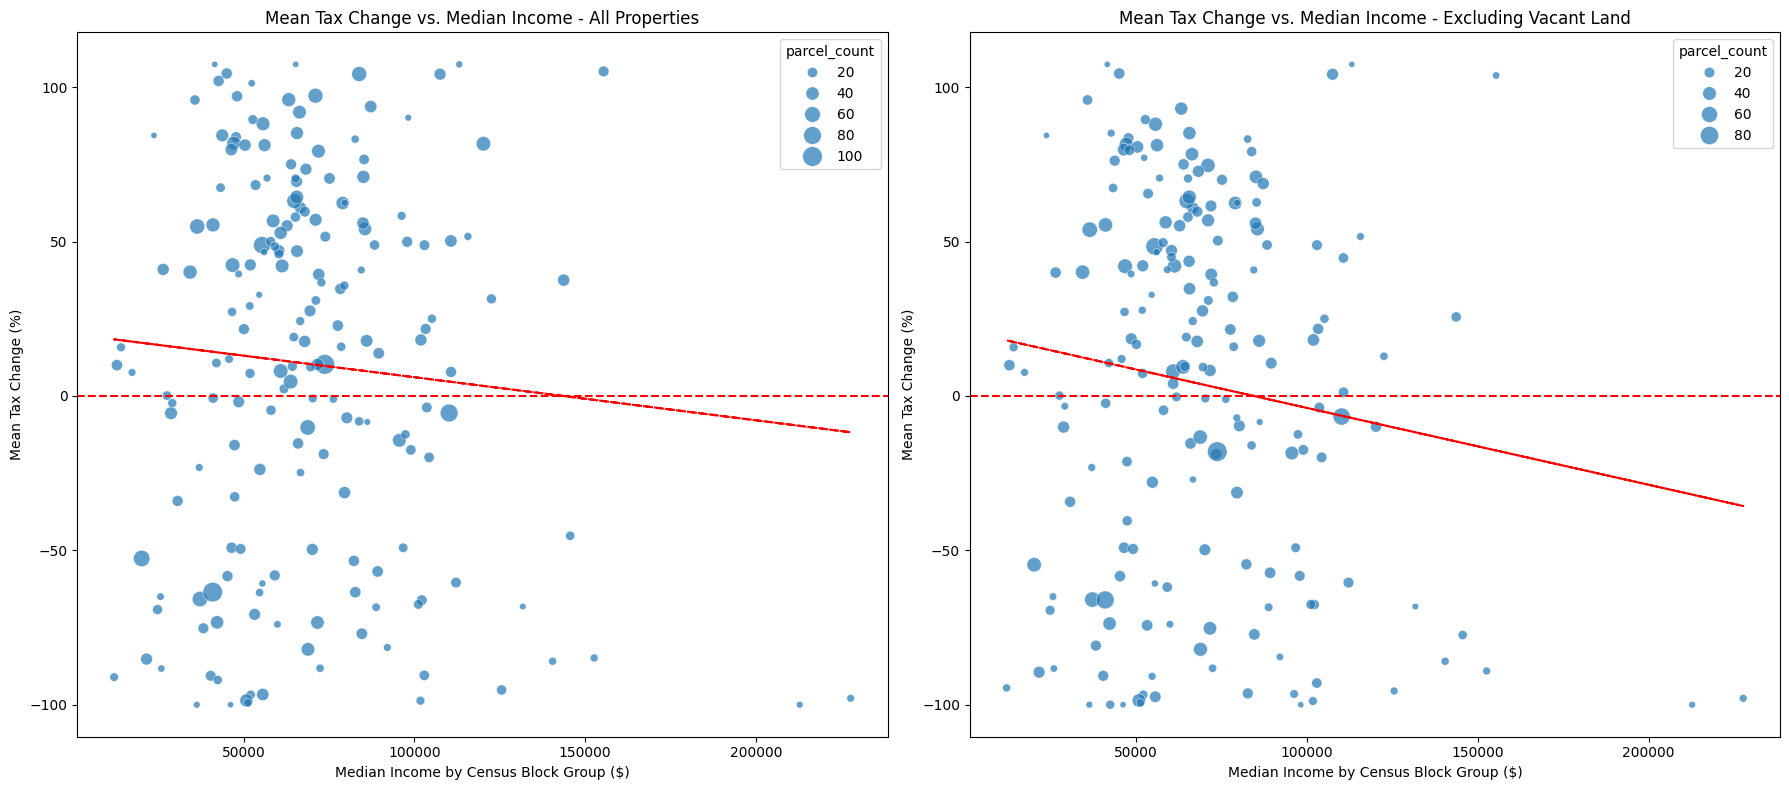

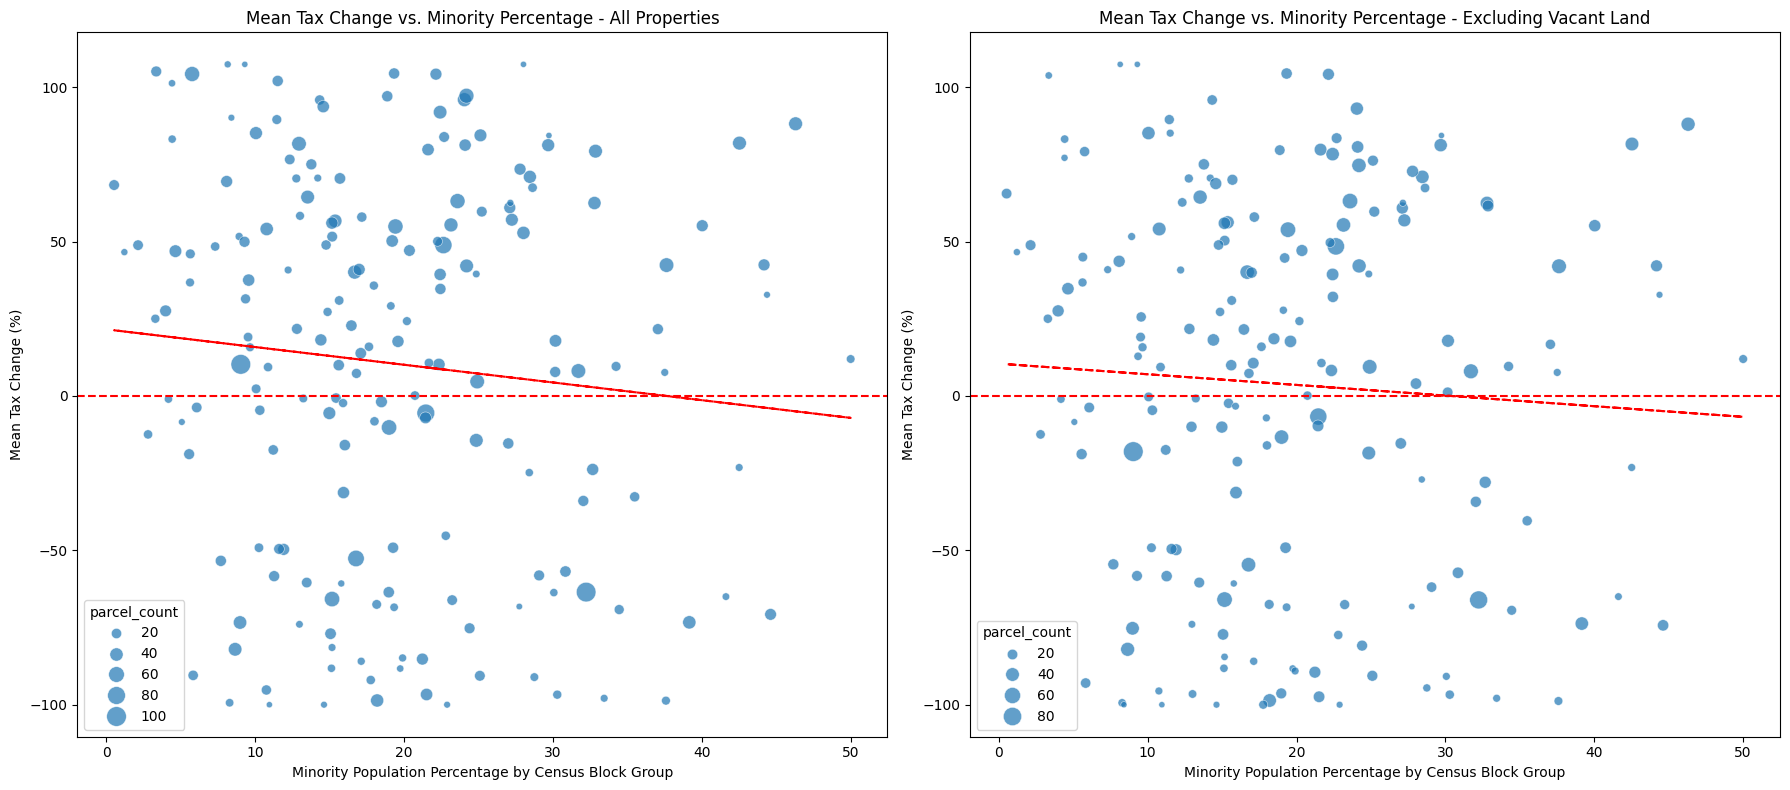

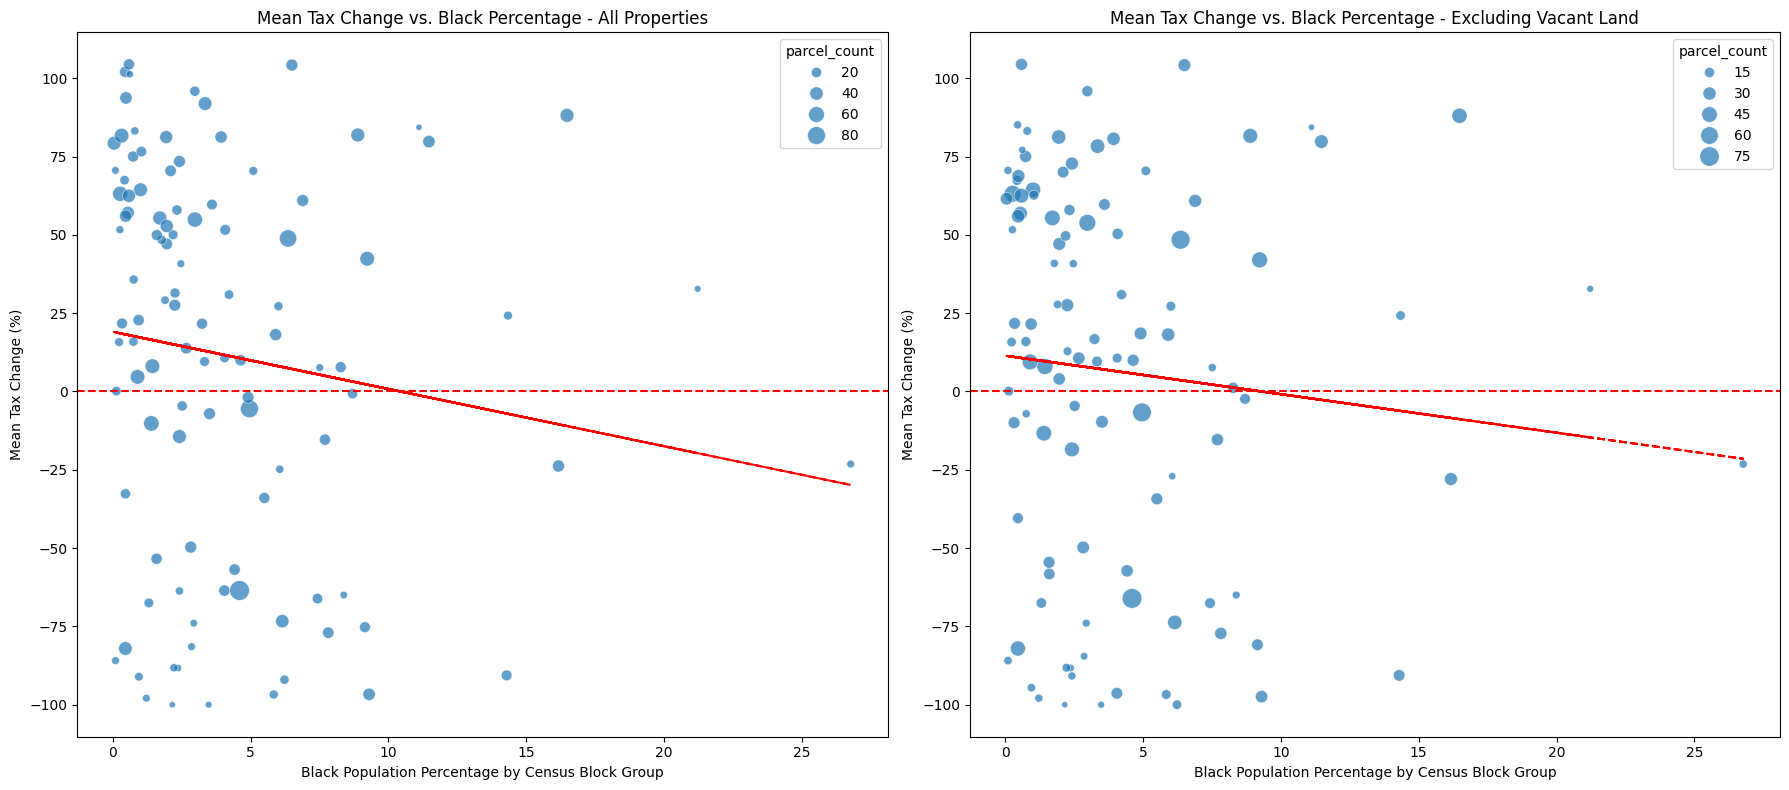

Correlation income_mean_all: -0.0725
Correlation income_median_all: -0.2739
Correlation minority_mean_all: -0.0897
Correlation black_mean_all: -0.0757
Correlation income_mean_non_vacant: -0.1305
Correlation income_median_non_vacant: -0.3455
Correlation minority_mean_non_vacant: -0.0534
Correlation black_mean_non_vacant: -0.0336

Tax impact by income quintile (all properties):


/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_19924/1655537101.py:94: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(f'{group_col}_quintile').agg(
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_19924/1655537101.py:94: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(f'{group_col}_quintile').agg(
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_19924/1655537101.py:94: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obser

,median_income_quintile,count,mean_tax_change,median_tax_change,mean_value
0,Q1 (Lowest),937,-58.981544,6.465396,34823.719317
1,Q2,925,-25.675456,9.267067,52599.902703
2,Q3,920,40.897272,9.435525,65155.176087
3,Q4,931,41.731279,6.465396,76837.378088
4,Q5 (Highest),912,41.428081,-3.185462,107709.960526



Tax impact by income quintile (excluding vacant land):


,median_income_quintile,count,mean_tax_change,median_tax_change,mean_value
0,Q1 (Lowest),839,-76.059093,5.387830,35336.301549
1,Q2,826,-33.564794,9.698093,52746.812349
2,Q3,818,32.119092,9.482580,64973.405868
3,Q4,813,-6.008530,4.002944,75684.599016
4,Q5 (Highest),822,9.059636,-7.926860,103922.487835



Tax impact by minority percentage quintile (all properties):


,minority_pct_quintile,count,mean_tax_change,median_tax_change,mean_value
0,Q1 (Lowest),938,36.865470,3.369905,7.443678
1,Q2,915,-9.481025,3.879237,14.413005
2,Q3,924,1.522615,2.029068,19.338160
3,Q4,924,82.712280,11.637712,24.351245
4,Q5 (Highest),924,-74.127164,8.189501,35.135130



Tax impact by minority percentage quintile (excluding vacant land):


,minority_pct_quintile,count,mean_tax_change,median_tax_change,mean_value
0,Q1 (Lowest),826,-15.243227,0.118532,7.593051
1,Q2,836,-69.103487,2.060589,14.680526
2,Q3,817,24.853468,0.215513,19.694565
3,Q4,844,68.772649,11.314442,24.616979
4,Q5 (Highest),795,-88.918961,6.812464,35.623044


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def filter_data(df):
    """Filter data to remove negative or zero median incomes and create non-vacant subset (also with positive income)"""
    df_filtered = df[df['median_income'] > 0].copy()
    non_vacant_df = df[(df['PROPERTY_CATEGORY'] != 'Vacant Land') & (df['median_income'] > 0)].copy()
    return df_filtered, non_vacant_df

def calculate_block_group_summary(df):
    """Calculate summary statistics for census block groups, excluding negative/zero median incomes"""
    # Only include block groups with positive median income
    df = df[df['median_income'] > 0].copy()
    summary = df.groupby('std_geoid').agg(
        median_income=('median_income', 'first'),
        minority_pct=('minority_pct', 'first'),
        black_pct=('black_pct', 'first'),
        total_current_tax=('current_tax', 'sum'),
        total_new_tax=('new_tax', 'sum'),
        mean_tax_change=('tax_change', 'mean'),
        median_tax_change=('tax_change', 'median'),
        median_tax_change_pct=('tax_change_pct', 'median'),
        parcel_count=('tax_change', 'count'),
        has_vacant_land=('PROPERTY_CATEGORY', lambda x: 'Vacant Land' in x.values)
    ).reset_index()
    # Exclude block groups with non-positive median income (shouldn't be needed, but for safety)
    summary = summary[summary['median_income'] > 0].copy()
    summary['mean_tax_change_pct'] = ((summary['total_new_tax'] - summary['total_current_tax']) / 
                                    summary['total_current_tax']) * 100
    return summary

def create_scatter_plot(data, x_col, y_col, ax, title, xlabel, ylabel):
    """Create a scatter plot with trend line, excluding negative/zero incomes"""
    # Exclude rows with non-positive x_col (e.g., median_income)
    data = data[data[x_col] > 0].copy()
    sns.scatterplot(
        data=data,
        x=x_col,
        y=y_col,
        size='parcel_count',
        sizes=(20, 200),
        alpha=0.7,
        ax=ax
    )
    
    ax.axhline(y=0, color='r', linestyle='--')
    
    x = data[x_col].dropna()
    y = data[y_col].dropna()
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    if len(x[mask]) > 1:
        z = np.polyfit(x[mask], y[mask], 1)
        p = np.poly1d(z)
        ax.plot(x[mask], p(x[mask]), "r--")
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

def plot_comparison(data1, data2, x_col, y_col, title_prefix, xlabel):
    """Create side-by-side comparison plots, excluding negative/zero incomes"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    create_scatter_plot(data1, x_col, y_col, ax1, 
                       f'{title_prefix} - All Properties', xlabel, 'Mean Tax Change (%)')
    create_scatter_plot(data2, x_col, y_col, ax2,
                       f'{title_prefix} - Excluding Vacant Land', xlabel, 'Mean Tax Change (%)')
    
    plt.tight_layout()
    plt.show()

def calculate_correlations(data1, data2):
    """Calculate correlations between variables, excluding negative/zero incomes"""
    correlations = {}
    for df, suffix in [(data1, 'all'), (data2, 'non_vacant')]:
        # Exclude rows with non-positive median_income for correlation
        df_corr = df[df['median_income'] > 0].copy()
        correlations[f'income_mean_{suffix}'] = df_corr[['median_income', 'mean_tax_change_pct']].corr().iloc[0, 1]
        correlations[f'income_median_{suffix}'] = df_corr[['median_income', 'median_tax_change_pct']].corr().iloc[0, 1]
        correlations[f'minority_mean_{suffix}'] = df_corr[['minority_pct', 'mean_tax_change_pct']].corr().iloc[0, 1]
        correlations[f'black_mean_{suffix}'] = df_corr[['black_pct', 'mean_tax_change_pct']].corr().iloc[0, 1]
    return correlations

def create_quintile_summary(df, group_col, value_col):
    """Create summary statistics by quintiles, excluding negative/zero incomes for income-based quintiles"""
    # If grouping by income, exclude non-positive values
    if group_col == 'median_income':
        df = df[df['median_income'] > 0].copy()
    df[f'{group_col}_quintile'] = pd.qcut(df[group_col], 5, 
                                         labels=["Q1 (Lowest)", "Q2", "Q3", "Q4", "Q5 (Highest)"])
    
    summary = df.groupby(f'{group_col}_quintile').agg(
        count=('tax_change', 'count'),
        mean_tax_change=('tax_change', 'mean'),
        median_tax_change=('tax_change', 'median'),
        mean_value=(value_col, 'mean')
    ).reset_index()
    
    return summary

# Main execution
gdf_filtered, non_vacant_gdf = filter_data(df)
print(f"Number of rows in gdf_filtered: {len(gdf_filtered)}")
print(f"Number of rows in non_vacant_gdf: {len(non_vacant_gdf)}")

# Calculate block group summaries (all with positive median_income only)
census_block_groups = calculate_block_group_summary(gdf_filtered)
non_vacant_block_summary = calculate_block_group_summary(non_vacant_gdf)

# Create comparison plots (all with positive median_income only)
plot_comparison(census_block_groups, non_vacant_block_summary, 
               'median_income', 'mean_tax_change_pct', 
               'Mean Tax Change vs. Median Income', 
               'Median Income by Census Block Group ($)')

plot_comparison(census_block_groups, non_vacant_block_summary,
               'minority_pct', 'mean_tax_change_pct',
               'Mean Tax Change vs. Minority Percentage',
               'Minority Population Percentage by Census Block Group')

plot_comparison(census_block_groups, non_vacant_block_summary,
               'black_pct', 'mean_tax_change_pct',
               'Mean Tax Change vs. Black Percentage',
               'Black Population Percentage by Census Block Group')

# Calculate and print correlations (all with positive median_income only)
correlations = calculate_correlations(census_block_groups, non_vacant_block_summary)
for key, value in correlations.items():
    print(f"Correlation {key}: {value:.4f}")

# Create and display quintile summaries (income quintiles exclude negative/zero incomes)
income_quintile_summary = create_quintile_summary(gdf_filtered, 'median_income', 'median_income')
non_vacant_income_quintile_summary = create_quintile_summary(non_vacant_gdf, 'median_income', 'median_income')
minority_quintile_summary = create_quintile_summary(gdf_filtered, 'minority_pct', 'minority_pct')
non_vacant_minority_quintile_summary = create_quintile_summary(non_vacant_gdf, 'minority_pct', 'minority_pct')

print("\nTax impact by income quintile (all properties):")
display(income_quintile_summary)
print("\nTax impact by income quintile (excluding vacant land):")
display(non_vacant_income_quintile_summary)
print("\nTax impact by minority percentage quintile (all properties):")
display(minority_quintile_summary)
print("\nTax impact by minority percentage quintile (excluding vacant land):")
display(non_vacant_minority_quintile_summary)


In [26]:
# Import our new policy analysis functions
import sys
sys.path.append('..')  # Add parent directory to path
from policy_analysis import (
    analyze_vacant_land, 
    analyze_parking_lots, 
    calculate_development_tax_penalty,
    print_vacant_land_summary,
    print_parking_analysis_summary, 
    print_development_penalty_summary
)


In [27]:
## Policy Analysis: Vacant Land Speculation

# Let's see if we have owner information in our dataset
print("Columns that might contain owner information:")
owner_cols = [col for col in df.columns if 'owner' in col.lower() or 'name' in col.lower()]
print(owner_cols)

# Filter out fully exempt properties for analysis
df_non_exempt = df[df['full_exmp'] == 0].copy()
print(f"Excluding {(df['full_exmp'] == 1).sum():,} fully exempt properties from analysis")
print(f"Analysis dataset: {len(df_non_exempt):,} properties (down from {len(df):,})")

# Run vacant land analysis excluding fully exempt land
vacant_analysis = analyze_vacant_land(
    df=df_non_exempt,
    land_value_col='land_value',
    property_type_col='prop_use_desc', 
    neighborhood_col='nbhd_name',
    vacant_identifier='Vacant Land',
    improvement_value_col='improvement_value',
    exemption_col='exmp_amt',
    exemption_flag_col='full_exmp'
)

# Print formatted summary
print_vacant_land_summary(vacant_analysis)


Columns that might contain owner information:
['nbhd_name', 'site_str_name', 'NAME', 'BASENAME']
Excluding 1,400 fully exempt properties from analysis
Analysis dataset: 3,396 properties (down from 4,796)
VACANT LAND ANALYSIS SUMMARY
Total vacant parcels: 36
Total vacant land value: $2,985,555
Average vacant land value: $82,932
Vacant land as % of total city land value: 1.8%

Top 5 neighborhoods by vacant land value:
           count  total_value  avg_value  median_value
nbhd_name                                             
4134M          4     718580.0  179645.00      172105.0
4653M          4     576556.0  144139.00      101095.5
6770M          1     356260.0  356260.00      356260.0
ESEVN          2     318320.0  159160.00      159160.0
CANBL          3     270170.0   90056.67       79900.0


In [28]:
## Policy Analysis: Parking Lot Efficiency

# Run parking lot analysis excluding fully exempt land
parking_analysis = analyze_parking_lots(
    df=df_non_exempt,
    land_value_col='land_value',
    improvement_value_col='improvement_value',
    property_type_col='prop_use_desc',
    parking_identifier='Trans - Parking',
    min_land_value_threshold=50000,  # Focus on land worth $50k+
    max_improvement_ratio=0.1,  # Improvement value <= 10% of land value
    exemption_col='exmp_amt',
    exemption_flag_col='full_exmp'
)

# Print formatted summary
print_parking_analysis_summary(parking_analysis)

# Show detailed breakdown by land value tier
if 'by_land_value_tier' in parking_analysis:
    print("\nDetailed breakdown by land value tier:")
    print(parking_analysis['by_land_value_tier'].to_string())


PARKING LOT EFFICIENCY ANALYSIS
Total parking lots: 5
Total parking land value: $3,285,689
Average parking land value: $657,138
Average improvement ratio: 82.2%

Underutilized parking lots (Land value >= $50,000 and improvement ratio <= 10.0%):
Count: 4
Total land value: $2,462,759
Average land value: $615,690

Development potential:
Current improvement value: $0
Potential improvement value: $4,127,715
Untapped development value: $4,127,715

Detailed breakdown by land value tier:
                 count  total_land_value  avg_land_value  avg_improvement_ratio
land_value_tier                                                                
<$25k                0               0.0             NaN                    NaN
$25k-$50k            0               0.0             NaN                    NaN
$50k-$100k           1           50873.0         50873.0                  0.000
$100k-$250k          0               0.0             NaN                    NaN
>$250k               4         3234

/Users/gregmiller/Documents/CLE/cle/LVTShift/examples/../policy_analysis.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_analysis = tier_df.groupby('land_value_tier').agg({


In [29]:
# Import new property analysis functions
from policy_analysis import (
    analyze_property_values_by_category, 
    print_property_values_summary
)


In [30]:
## Property Value Analysis by Category

# Analyze property values by category including exemptions
property_values = analyze_property_values_by_category(
    df=df,
    category_col='PROPERTY_CATEGORY', 
    land_value_col='land_value',
    improvement_value_col='improvement_value',
    exemption_col='exmp_amt',
    exemption_flag_col='full_exmp'
)

# Print formatted summary
print_property_values_summary(property_values, "Spokane Property Values by Category")


SPOKANE PROPERTY VALUES BY CATEGORY
             PROPERTY_CATEGORY total_land_value  property_count total_improvement_value improvement_land_ratio total_exemptions non_exempt_land_value non_exempt_improvement_value non_exempt_improvement_land_ratio  fully_exempt_count
     Retail/Service/Commercial     $525,023,590             594          $3,205,228,950                   6.10   $3,327,298,182           $66,359,029                 $169,898,968                              2.56                 495
                 Single Family     $302,076,470            3359            $786,579,300                   2.60   $1,004,541,362           $61,985,757                  $19,023,201                              0.31                 249
                   Vacant Land     $105,793,940             522              $8,656,100                   0.08      $67,651,675            $2,985,555                      $13,000                              0.00                 486
 Large Multi-Family (5+ units)  

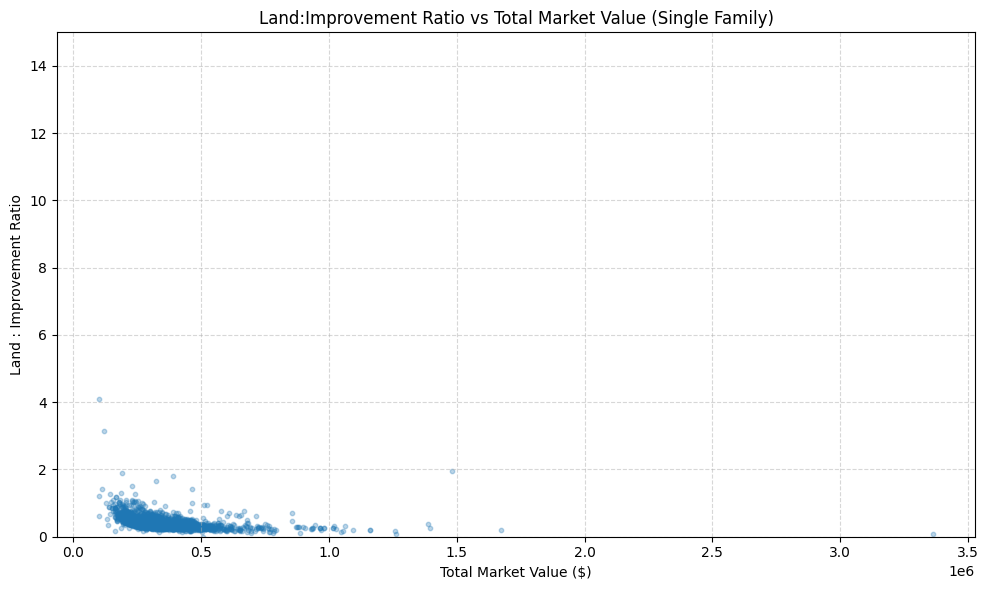

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Filter for single-family housing category
sf_df = df[df['PROPERTY_CATEGORY'] == 'Single Family']

# Calculate land:improvement ratio and total market value
land = sf_df['land_value']
improvement = sf_df['improvement_value']
total_value = land + improvement

# Avoid division by zero
ratio = np.where(improvement > 0, land / improvement, np.nan)

# Scatter plot (non-log axes), restrict y-axis to less than 3
plt.figure(figsize=(10, 6))
plt.scatter(total_value, ratio, alpha=0.3, s=10)
plt.xlabel('Total Market Value ($)')
plt.ylabel('Land : Improvement Ratio')
plt.title('Land:Improvement Ratio vs Total Market Value (Single Family)')
plt.ylim(0, 15)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [32]:
## Policy Analysis: Development Tax Penalty

# Calculate the perverse incentive of building taxes
# Using the current building millage rate from the split-rate system we modeled
building_millage = 1.1238 / 1000  # Convert from per-thousand to decimal

penalty_analysis = calculate_development_tax_penalty(
    df=df,
    improvement_value_col='improvement_value',
    millage_rate=building_millage,  # Current building tax rate
    years=30,  # 30-year analysis horizon
    discount_rate=0.05,  # 5% discount rate
    typical_construction_cost_per_sqft=200,  # Spokane construction costs
    typical_unit_size_sqft=1200  # Typical housing unit size
)

# Print formatted summary
print_development_penalty_summary(penalty_analysis)

# Compare with LVT scenario (zero building tax)
print("\n" + "="*60)
print("COMPARISON: LVT ELIMINATES DEVELOPMENT PENALTY")
print("="*60)

lvt_penalty_analysis = calculate_development_tax_penalty(
    df=df,
    improvement_value_col='improvement_value',
    millage_rate=0.0,  # No building tax under pure LVT
    years=30,
    discount_rate=0.05,
    typical_construction_cost_per_sqft=200,
    typical_unit_size_sqft=1200
)

print(f"Current system development penalty: {penalty_analysis['equivalent_lost_units']:,.0f} housing units")
print(f"LVT system development penalty: {lvt_penalty_analysis['equivalent_lost_units']:,.0f} housing units")
print(f"Net housing units enabled by LVT: {penalty_analysis['equivalent_lost_units'] - lvt_penalty_analysis['equivalent_lost_units']:,.0f}")

# Show different scenarios with varying building tax rates
print("\n" + "="*60)
print("SCENARIO ANALYSIS: VARYING BUILDING TAX RATES")
print("="*60)

tax_rates = [0.005, 0.01, 0.015, 0.02, 0.025]  # 0.5% to 2.5%
scenarios = []

for rate in tax_rates:
    scenario = calculate_development_tax_penalty(
        df=df,
        improvement_value_col='improvement_value',
        millage_rate=rate,
        years=30,
        discount_rate=0.05,
        typical_construction_cost_per_sqft=200,
        typical_unit_size_sqft=1200
    )
    scenarios.append({
        'Tax Rate (%)': rate * 100,
        'NPV as % of Construction': scenario['npv_as_pct_of_construction_cost'],
        'Equivalent Lost Units': scenario['equivalent_lost_units'],
        'Lost Units as % of Stock': scenario['units_lost_percentage']
    })

scenario_df = pd.DataFrame(scenarios)
print(scenario_df.round(1).to_string(index=False))


DEVELOPMENT TAX PENALTY ANALYSIS
Analysis parameters:
  Building tax rate: 0.1%
  Time horizon: 30 years
  Discount rate: 5.0%

Results:
Total improvement value in city: $5,053,945,990
Annual building tax revenue: $5,679,625
NPV of building taxes (30 years): $87,309,750
NPV as % of construction cost: 1.7%

Housing impact analysis:
Equivalent 'lost' housing units: 364
Percentage of current housing stock: 5.5%

Interpretation:
  With a 0.1% building tax, the NPV of taxes over 30 years equals 1.7% of initial construction cost.
  This tax penalty is equivalent to losing 364 housing units (5.5% of current housing stock).
  Removing building taxes could enable 364 additional housing units to be economically viable.

COMPARISON: LVT ELIMINATES DEVELOPMENT PENALTY
Current system development penalty: 364 housing units
LVT system development penalty: 0 housing units
Net housing units enabled by LVT: 364

SCENARIO ANALYSIS: VARYING BUILDING TAX RATES
 Tax Rate (%)  NPV as % of Construction  Equiv

In [33]:
# Land value by improvement share categories (non-exempt basis)
from policy_analysis import analyze_land_by_improvement_share

# Run for all parcels
share_summary = analyze_land_by_improvement_share(
    df=df,
    land_value_col='land_value',
    improvement_value_col='improvement_value',
    exemption_col='exmp_amt',
    exemption_flag_col='full_exmp'
)

print("Adjusted total land value (non-exempt): ${:,.0f}".format(share_summary['total_adjusted_land_value']))
for row in share_summary['categories']:
    print("- {}: {:,} parcels | Adjusted land: ${:,.0f} ({:.1f}%)".format(
        row['category'], row['parcel_count'], row['adjusted_land_value'], row['share_of_total_land_value_pct']
    ))

# Now exclude vacant land and parking lots using PROPERTY_CATEGORY
exclude_categories = ["Vacant Land", "Transportation - Parking"]
df_non_vacant = df[~df["PROPERTY_CATEGORY"].isin(exclude_categories)]

share_summary_non_vacant = analyze_land_by_improvement_share(
    df=df_non_vacant,
    land_value_col='land_value',
    improvement_value_col='improvement_value',
    exemption_col='exmp_amt',
    exemption_flag_col='full_exmp'
)

print("\n(Excluding Vacant Land and Transportation - Parking)")
print("Adjusted total land value (non-exempt, non-vacant): ${:,.0f}".format(share_summary_non_vacant['total_adjusted_land_value']))
for row in share_summary_non_vacant['categories']:
    print("- {}: {:,} parcels | Adjusted land: ${:,.0f} ({:.1f}%)".format(
        row['category'], row['parcel_count'], row['adjusted_land_value'], row['share_of_total_land_value_pct']
    ))


Adjusted total land value (non-exempt): $167,535,475
- 0% improvement: 33 parcels | Adjusted land: $2,216,991 (1.3%)
- <10% improvement (excl. 0%): 8 parcels | Adjusted land: $1,249,108 (0.7%)
- 10-25% improvement: 8 parcels | Adjusted land: $1,176,175 (0.7%)
- 25-50% improvement: 28 parcels | Adjusted land: $2,141,711 (1.3%)

(Excluding Vacant Land and Transportation - Parking)
Adjusted total land value (non-exempt, non-vacant): $161,264,231
- 0% improvement: 7 parcels | Adjusted land: $853,301 (0.5%)
- <10% improvement (excl. 0%): 2 parcels | Adjusted land: $180,821 (0.1%)
- 10-25% improvement: 2 parcels | Adjusted land: $65,500 (0.0%)
- 25-50% improvement: 28 parcels | Adjusted land: $2,141,711 (1.3%)
